In [1]:
import sys
sys.path.append('..')
import GPflow
import svconvgp.svsumgp as sumgp

In [2]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.Z.value, m.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = -m._objective(m.get_free_state())[0]
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

In [3]:
X = np.random.rand(100, 1) * 6
Y = 0.6 * X + 0.3 * np.sin(1.5 * np.pi * X) + np.random.randn(*X.shape) * 0.1
Y -= np.mean(Y)

array([ 45.3492964])

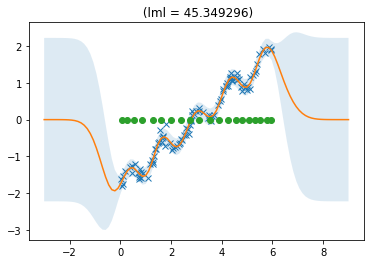

In [25]:
rbf = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1), X[:20, :].copy())
rbf.kern.lengthscales = 0.5
rbf.likelihood.variance = 0.1
rbf.optimize()
plot_model(rbf)

array([ 50.67542444])

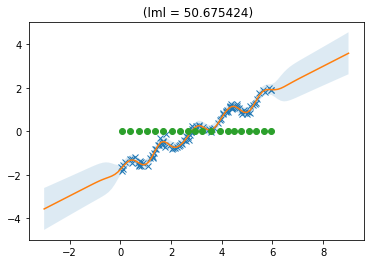

In [5]:
rbflin = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1) + GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1),
                          X[:20, :].copy())
rbflin.kern.rbf.variance = 0.3
rbflin.kern.rbf.lengthscales = 0.5
rbflin.optimize()
plot_model(rbflin)

50.667150854874578

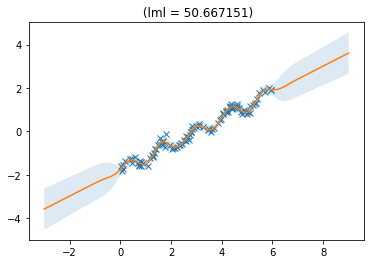

In [7]:
sumrbflin_full = sumgp.FullSVSumGP(X, Y, GPflow.kernels.RBF(1), GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1),
                                   GPflow.likelihoods.Gaussian(), rbflin.Z.value.copy(), np.array([[0], [6]]))
sumrbflin_full.Z1.fixed = True
sumrbflin_full.Z2.fixed = True
sumrbflin_full.kern1.variance = rbflin.kern.rbf.variance.value
sumrbflin_full.kern1.lengthscales = rbflin.kern.rbf.lengthscales.value
sumrbflin_full.kern2.variance = rbflin.kern.linear.variance.value
sumrbflin_full.kern1.fixed = True
sumrbflin_full.kern2.fixed = True
sumrbflin_full.optimize()
sumrbflin_full.kern1.fixed = False
sumrbflin_full.kern2.fixed = False
sumrbflin_full.optimize()
plot_model(sumrbflin_full)

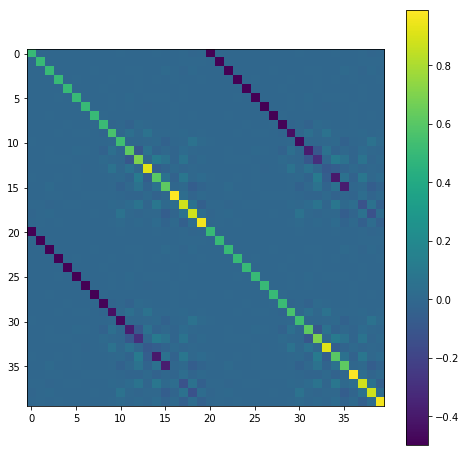

In [41]:
cov = np.dot(sumrbflin_full.q_sqrt.value[:, :, 0], sumrbflin_full.q_sqrt.value[:, :, 0].T)
plt.figure(figsize=(8, 8))
plt.imshow(cov)
plt.colorbar()

46.278676197402902

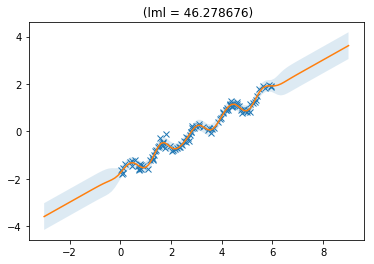

In [12]:
sumrbflin_mf = sumgp.MeanFieldSVSumGP(X, Y, GPflow.kernels.RBF(1), GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1),
                                      GPflow.likelihoods.Gaussian(), rbflin.Z.value.copy(), rbflin.Z.value.copy())
sumrbflin_mf.Z1.fixed = True
sumrbflin_mf.Z2.fixed = True
sumrbflin_mf.kern1.variance = rbflin.kern.rbf.variance.value
sumrbflin_mf.kern1.lengthscales = rbflin.kern.rbf.lengthscales.value
sumrbflin_mf.kern2.variance = rbflin.kern.linear.variance.value
sumrbflin_mf.kern1.fixed = True
sumrbflin_mf.kern2.fixed = True
sumrbflin_mf.optimize()
sumrbflin_mf.kern1.fixed = False
sumrbflin_mf.kern2.fixed = False
sumrbflin_mf.optimize()
plot_model(sumrbflin_mf)

In [15]:
sumrbflin_mf.kern1

Name,values,prior,constraint
kern1.lengthscales,[ 0.33667129],None,+ve
kern1.variance,[ 0.06690005],None,+ve


In [16]:
sumrbflin_full.kern1

Name,values,prior,constraint
kern1.lengthscales,[ 0.36039104],None,+ve
kern1.variance,[ 0.09039108],None,+ve


In [18]:
sumrbflin_mf.kern2

Name,values,prior,constraint
kern2.constant.variance,[ 2.98731001],None,+ve
kern2.linear.variance,[ 0.35031845],None,+ve


In [19]:
sumrbflin_full.kern2

Name,values,prior,constraint
kern2.constant.variance,[ 3.79090349],None,+ve
kern2.linear.variance,[ 0.35627562],None,+ve


## Really mean example

array([ 45.34938212])

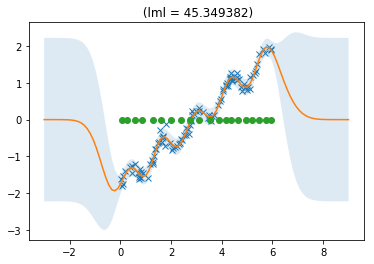

In [35]:
rbf2 = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1) + GPflow.kernels.RBF(1), X[:20, :].copy())
rbf2.kern.rbf_1.lengthscales = rbf.kern.lengthscales.value.copy()
rbf2.kern.rbf_2.lengthscales = rbf.kern.lengthscales.value.copy()
rbf2.kern.rbf_1.variance = rbf.kern.variance.value.copy() * 0.5
rbf2.kern.rbf_2.variance = rbf.kern.variance.value.copy() * 0.5
rbf2.kern.fixed = True
rbf2.likelihood.variance = 0.1
rbf2.optimize()
plot_model(rbf2)

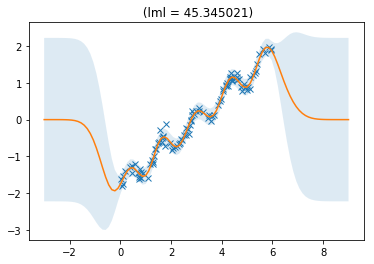

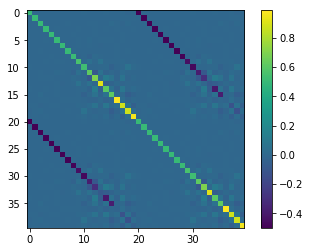

In [45]:
sumrbflin_full = sumgp.FullSVSumGP(X, Y, rbf2.kern.rbf_1, rbf2.kern.rbf_2,
                                   GPflow.likelihoods.Gaussian(), rbf2.Z.value.copy(), rbf2.Z.value.copy())
sumrbflin_full.kern1.fixed = True
sumrbflin_full.kern2.fixed = True
sumrbflin_full.Z1.fixed = True
sumrbflin_full.Z2.fixed = True
sumrbflin_full.optimize()
plot_model(sumrbflin_full)
cov = np.dot(sumrbflin_full.q_sqrt.value[:, :, 0], sumrbflin_full.q_sqrt.value[:, :, 0].T)
plt.figure()
plt.imshow(cov)
plt.colorbar()

17.816217618658669

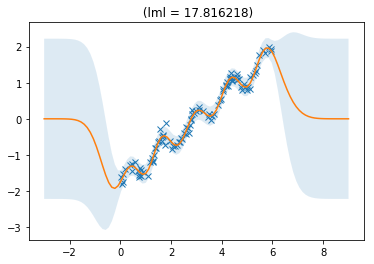

In [49]:
sumrbflin_mf = sumgp.MeanFieldSVSumGP(X, Y, rbf2.kern.rbf_1, rbf2.kern.rbf_2,
                                      GPflow.likelihoods.Gaussian(), rbf2.Z.value.copy(), rbf2.Z.value.copy())
sumrbflin_mf.kern1.fixed = True
sumrbflin_mf.kern2.fixed = True
sumrbflin_mf.Z1.fixed = True
sumrbflin_mf.Z2.fixed = True
sumrbflin_mf.optimize()
plot_model(sumrbflin_mf)

45.337740961584856

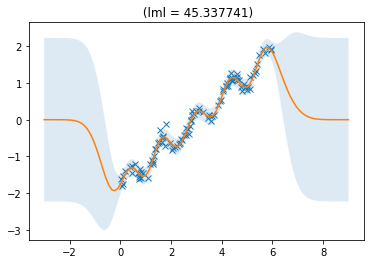

In [53]:
sumrbflin_mf.kern1.fixed = False
sumrbflin_mf.kern2.fixed = False
sumrbflin_mf.Z1.fixed = False
sumrbflin_mf.Z2.fixed = False
sumrbflin_mf.kern1.variance = sumrbflin_mf.kern1.variance.value + 0.001
sumrbflin_mf.optimize()
plot_model(sumrbflin_mf)

In [62]:
sumrbflin_mf.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 1.27449772],None,+ve
kern2.variance,[ 2.30585003e-06],None,+ve


## Test for equality

array([ 49.97055764])

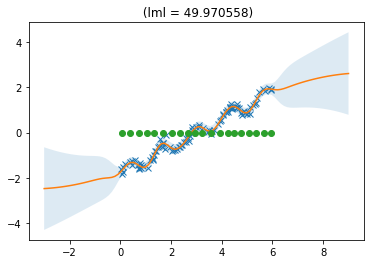

In [60]:
rbf3 = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1) + GPflow.kernels.RBF(1), X[:20, :].copy())
rbf3.kern.rbf_1.lengthscales = 2
rbf3.likelihood.variance = 0.1
rbf3.optimize()
plot_model(rbf3)

42.741098369910453

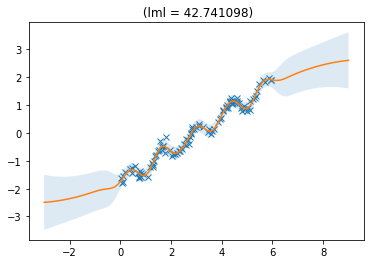

In [110]:
sumrbflin_mf = sumgp.MeanFieldSVSumGP(X, Y, rbf3.kern.rbf_1, rbf3.kern.rbf_2,
                                      GPflow.likelihoods.Gaussian(), rbf3.Z.value.copy(), rbf3.Z.value.copy())
sumrbflin_mf.kern1.fixed = True
sumrbflin_mf.kern2.fixed = True
sumrbflin_mf.Z1.fixed = True
sumrbflin_mf.Z2.fixed = True
sumrbflin_mf.optimize()
plot_model(sumrbflin_mf)

In [119]:
sumrbflin_full = sumgp.FullSVSumGP(X, Y, rbf3.kern.rbf_1, rbf3.kern.rbf_2,
                                   GPflow.likelihoods.Gaussian(), rbf3.Z.value.copy(), rbf3.Z.value.copy())
sumrbflin_full.q_mu = sumrbflin_mf.q_mu.value.T.flatten()[:, None]
mf_cov = np.zeros((2 * len(sumrbflin_mf.Z1.value), 2 * len(sumrbflin_mf.Z1.value)))
mf_cov[:20, :20] = sumrbflin_mf.q_sqrt.value[:, :, 0]
mf_cov[20:, 20:] = sumrbflin_mf.q_sqrt.value[:, :, 1]
sumrbflin_full.q_sqrt = mf_cov[:, :, None]
sumrbflin_full.likelihood = sumrbflin_mf.likelihood
sumrbflin_full._compile()

42.741098369909885

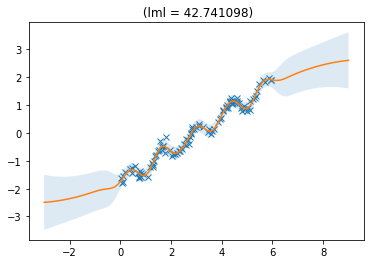

In [120]:
plot_model(sumrbflin_full)

49.970689541196535

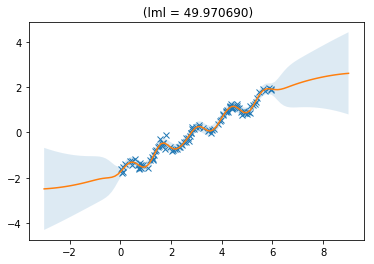

In [121]:
sumrbflin_full.optimize()
plot_model(sumrbflin_full)